## Final Project Research Question

In my first assignment, I argued that the #LetsGoBrandon hashtag is an argument symbolic legisign, with each instantiation of the hashtag serving as a sinsign replica of the original legisign. The hashtag symbolizes the user's political opposition to Joe Biden, justified by the argument that his policy decisions have resulted in negative outcomes. 

For my research project I ask the question, "What are the factors driving the #LetsGoBrandon hashtag's popularity?"

## Digital Data Sources

#LetsGoBrandon is a social media hashtag primarily used on Twitter. To answer my question I construct and save a database of 10,000 tweets that include the hashtag using the Twitter API and Tweepy. 

I then execute my analysis in three parts. The first involves identifying accounts tagged and hashtags included in these tweets alongside #LetsGoBrandon. This allows me to determine the types of accounts and accompanying tags that are associated with #LetsGoBrandon. If particular accounts/tags are responsible for propagating the spread and consistent use of the hashtag, they will be frequently mentioned by users.

The second involves conducting a sentiment analysis of the tweets, splitting them into positive and negative subsets of the data to identify variations in the use of the hashtag to express political opposition to the president. I can then determine if there are unique satiricial/vitirolic elements that are associated with the hashtag's use that can be used to explain its popularity.

The third involves performing an n-gram analysis of tweets. This allows me to identify the common points and arguments made by users when they utilize the hashtag. These arguments provide #LetsGoBrandon with validity as a a criticism of Joe Biden, allowing me to identify the issues that resonate strongest with the hashtag's users.

## Download Data

### Step 1: Import Packages

In [1]:
import tweepy
import pandas as pd
import time
import re
from textblob import TextBlob
import sys
import matplotlib.pyplot as plt
import os
import nltk
import pycountry
import string
from wordcloud import WordCloud, STOPWORDS
from PIL import Image
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk import bigrams
from nltk import trigrams
import itertools
import collections
from langdetect import detect
from nltk.stem import SnowballStemmer
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from sklearn.feature_extraction.text import CountVectorizer
import numpy as np

### Step 2: Scrape Tweets and Build Database

I use the Tweepy API to scrape 10,000 Tweets containing either #LetsGoBrandon or #letsgobrandon. The Tweepy API imposes limits on how many tweets a user can scrape, and while other tools such as Twint do not have such restrictions, Tweepy provides additional functionality for deeper analysis.

My API call successfully scraped about 7,382 unique tweets using Tweepy which I have already saved in a json file. I read the file at the end of the section so do skip ahead if you are not going to execute this query.

In [9]:
#API keys and authentication
consumer_key = "7tuzJV74YrymNg3x3HERtyamk"
consumer_secret = "dvtfaPmdsMnX1IthwB5Ho7WYRdlcZUzr7P70LOuOuZTcyapiYw"
access_token = "1191313455392804864-opJS8O0Dz7feptJJ5YgQEN8QU6l137"
access_token_secret = "4I9EF2JmbaZpc556mtFToM2wrNz7q7p2oLJ6tO4KoybCr"

auth = tweepy.OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_token, access_token_secret)
api = tweepy.API(auth,wait_on_rate_limit=True)

Items to Scrape from Tweets (in order)
 - Date and Time of Tweet
     - For possible time series analysis
 - Text of Tweet
     - For text analysis
 - No. of Favorites
     - To understand how popular tweets with #LetsGoBrandon are
 - No. of Retweets
     - To understand the reach of these tweets
 - If Tweet is a Reply, the ID of the user ID it is in reply to
     - With these IDs we can map out a full network of accounts associated with the hashtag (deeper analysis)
 - Is the Tweet a Quote Tweet?
     - Determine if tweets are motivated primarily as a response or are original content
 - Is The Tweeeting Account verified?
     - Determine how many influencers are currently involved in its propagation
 - Username of Tweet poster
     - Identify accounts using the hashtag

In [11]:
text_query = '#LetsGoBrandon OR #letsgobrandon'
count = 10000

try:
 # Creation of query method using parameters
    tweets = tweepy.Cursor(api.search_tweets,q=text_query).items(count)
 
 # Pulling information from tweets iterable object
    tweets_list = [[tweet.created_at, tweet.id_str, tweet.text, tweet.favorite_count, \
                    tweet.retweet_count, tweet.in_reply_to_status_id_str, \
                    tweet.in_reply_to_user_id_str, tweet.is_quote_status, \
                    tweet.user.verified, tweet.user.screen_name] for tweet in tweets]
 
 # Creation of dataframe from tweets list
 # Add or remove columns as you remove tweet information
    tweets_df = pd.DataFrame(tweets_list, columns = ['Tweet DateTime', 'Tweet ID', \
                                                     'Tweet Text', 'Favourites', 'Retweets', \
                                                     'Replied Tweet Status ID str', \
                                                     'Replied Tweet User ID str', \
                                                     'Quote Status Bool', 'Verified Status Bool',\
                                                     'Screen Name'])
    

except BaseException as e:
    print('failed on_status,',str(e))
    time.sleep(3)

Rate limit reached. Sleeping for: 795
Rate limit reached. Sleeping for: 827
Rate limit reached. Sleeping for: 814


__Explore Dataframe__

In [12]:
tweets_df.head()

,Tweet DateTime,Tweet ID,Tweet Text,Favourites,Retweets,Replied Tweet Status ID str,Replied Tweet User ID str,Quote Status Bool,Verified Status Bool,Screen Name
0,2022-02-16 17:01:08+00:00,1493993860908912653,RT @RandyRRQuaid: Trudeau’s nasty speech where...,0,1258,None,None,False,False,MountainMama215
1,2022-02-16 17:01:03+00:00,1493993841891823617,By Far! #LetsGoBrandon https://t.co/fEVAoQLke2,0,0,None,None,True,False,1revor1
2,2022-02-16 17:00:06+00:00,1493993603454095369,@catturd2 Let’s just face it…Putin is scared o...,0,0,1493652911792005122,1043185714437992449,False,False,2Borbons
3,2022-02-16 16:59:14+00:00,1493993383832043520,RT @US_of_A_1st: @JoeBiden is not a @POTUS \n\...,0,14,None,None,True,False,RShaffer1
4,2022-02-16 16:59:05+00:00,1493993347639304196,#FJB #LetsGoBrandon,0,0,None,None,False,False,gballz24


In [3]:
tweets_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10569 entries, 0 to 10568
Data columns (total 10 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   Tweet DateTime               10569 non-null  int64  
 1   Tweet ID                     10569 non-null  int64  
 2   Tweet Text                   10569 non-null  object 
 3   Favourites                   10569 non-null  int64  
 4   Retweets                     10569 non-null  int64  
 5   Replied Tweet Status ID str  1815 non-null   float64
 6   Replied Tweet User ID str    2007 non-null   float64
 7   Quote Status Bool            10569 non-null  bool   
 8   Verified Status Bool         10569 non-null  bool   
 9   Screen Name                  10569 non-null  object 
dtypes: bool(2), float64(2), int64(4), object(2)
memory usage: 763.8+ KB


The Twitter API permitted scraping of only 10,659 Tweets before calling a time out on my API call.

__Save to JSON__

In [14]:
tweets_df.to_json(r'letsgobrandon_tweets.json')

__Manually Load JSON File if not scraping__

In [2]:
tweets_df = pd.read_json('letsgobrandon_tweets.json')

__Eliminate Duplicate Tweets__

In [103]:
tweets_df = tweets_df.drop_duplicates(subset="Tweet Text")

## Demonstrating Replicas From A Common Legisign

### Step 3: Exploring reach of Tweets

In [104]:
len(tweets_df)

7382

We have 7,382 unique tweets in our dataset

In [106]:
tweets_df["Favourites"].sum()

14678

Our Tweets have been liked a total of 14,678 times

In [107]:
tweets_df["Retweets"].sum()

30878

Our Tweets have been retweeted a total of 30,878 times

This does not give us a precise estimate of our hashtag's reach but we can reasonably assume that the number of people who have viewed the tag on their feeds or used the tag themselves is several orders of magnitude larger than the retweet/favourite numbers

In [108]:
tweets_df["Verified Status Bool"].describe()

count      7382
unique        2
top       False
freq       7344
Name: Verified Status Bool, dtype: object

Our Tweets are primarily spread with non-verified accounts, but there are 38 accounts which are verified

### Step 5: Analyze mentions and hashtags used with #LetsGoBrandon

In [4]:
lgb_regex = "\n"
stop_tags = ["#letsgobrandon", '#LetsGoBrandon', '#LGB', \
             '#LetsGoBrando…', '@JoeBiden.', '#LetsGoBrandon…',
             '#SuperBowl', '@RamsNFL']

#Dictionaries to store counts of hashtags and mentions



#Preprocessing:
# remove /n
# extract hashtags, account tags, main text
def metadata_extractor(tweet_series):
    '''
    This function extracts the unique mentions and hashtags used in all \
    tweets across our database with frequency counts in a dictionary
    
    Inputs:
        tweet_series: dataframe column with text of tweets (pandas series)
    
    Outputs:
        None
    '''
    hashtag_dict = {}
    mention_dict = {}
    for tweet in tweet_series:
        tweet = tweet.replace(lgb_regex, " ")
        tweet = tweet.split()
        for word in tweet:
            if word not in stop_tags:
                if word.startswith('@'):
                    if word not in mention_dict:
                        mention_dict[word] = 1
                    else:
                        mention_dict[word] += 1
                elif word.startswith("#"):
                    if word not in hashtag_dict:
                        hashtag_dict[word] = 1
                    else:
                        hashtag_dict[word] += 1
    return hashtag_dict, mention_dict

In [5]:
hashtags, mentions = metadata_extractor(tweets_df['Tweet Text'])

__Visualize Most Common Hashtags and Mentions__

<AxesSubplot:xlabel='hashtag'>

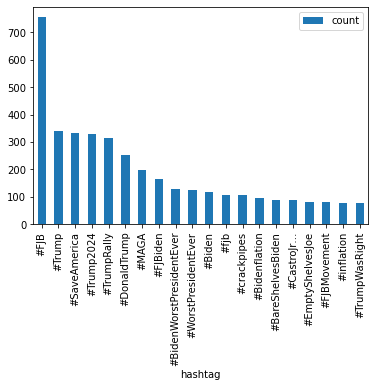

In [7]:
#Most common hashtags
hashtag_df = pd.DataFrame(hashtags.items(), columns = ['hashtag', 'count'])
hashtag_df = hashtag_df.sort_values(by='count', ascending=False)
hashtag_df[0:20].plot.bar(x='hashtag', y='count')

A majority of the hashtags used directly reference Joe Biden. The most frequently used tag is #FJB, an acronym for F** Joe Biden that also forms the basis of other hashtags such as #FJBMovement and #FJBiden. Hashtags such as #BidenWorstPresidentEver and #WorstPresidentEver communicate a similar level of vitriol for the current president.

Another set of hashtags reference specific negative issues commonly attributed to the Biden administration's policies by conservatives. Words like 'inflation' (#Bidenflation etc.) and 'crack' (#crackpipes) are used to criticise the Biden's administration's  economic and drug enforcement policies respectively. Although the accuracy of these critiques are debatable, they are held as ground truths by conservatives.

Interestingly, there are also hashtags which indicate support for Donald Trump such as #Trump2024 and #SaveAmerica, the name and slogan of Trump's potential 2024 presidential campaign respectively. There seems to be a common identity amongst users of this hashtag as conservative Trump supporters who are opposed to Biden. This opposition is then justified in retrospect through the abovementioned arguments fed to them via conservative media

<AxesSubplot:xlabel='hashtag'>

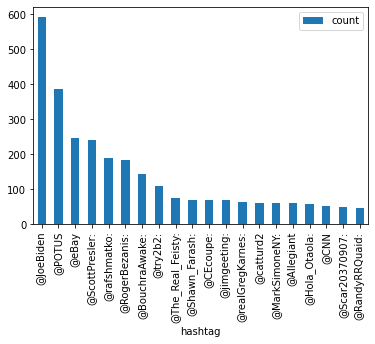

In [8]:
mention_df = pd.DataFrame(mentions.items(), columns = ['hashtag', 'count'])
mention_df = mention_df.sort_values(by='count', ascending=False)
mention_df[0:20].plot.bar(x='hashtag', y='count')

In [62]:
ebay_df = tweets_df.loc[tweets_df["Tweet Text"].str.contains(r"@eBay")]

In [67]:
ebay_df['Tweet Text'].iloc[0]

'RT @rafshmatko: #Trump2024 #Trump #SaveAmerica #LetsGoBrandon #TrumpRally #DonaldTrump  👉👉👉  https://t.co/1vOkFAXoev @eBay'

In [68]:
ebay_df['Tweet Text'].iloc[100]

'RT @rafshmatko: #SaveAmerica #LetsGoBrandon #TrumpRally #DonaldTrump  👉👉  https://t.co/t6isv6AWzE @eBay'

Surprisingly eBay is mentioned regularly in tweets containing the #LetsGoBrandon hashtag. When we explore tweets specifically mentioning eBay, we see that they primarily redirect to eBay ads for conservative merchandise. There is a clear attempt to commoditize users' political opinions to the benefits of the commercial interests of other users.

Apart from eBay, the most common mentions used alongside #LetsGoBrandon directly reference either the president or his administration (@POTUS, @JoeBiden). Users are most likely tagging these accounts with #LetsGoBrandon to openly communicate their political opposition, signal their political orientations to other conservatives, and elicit emotionally charged responses from the supporters of the president. 

Other mentions tag a variety of conservative influencers. @ScottPresler is a conservative activist with 917,000 followers affiliated with conservative youth group, Turning Point USA. @rafshmatk0 is a pro-trump sculptor with 4,622 followers who sculpts statues of Trump, and @Hola_Otaola is a pro-trump cuban american talk show host, with 18,000 followers. These accounts have a range of follower counts, indicating varying degrees of popularity and some, like Scott, also possess verified status, making them accounts of public interest.

Additionally, there are also a range of alternative medicine promoters amongst the most popular mentions who circulate anti-vaccine misinformation such as @RogerBezanis, with 471,500 followers. Anti-vaccine/homeopathy promoting accounts are typically affiliated with right-wing movements due to a common distrust of mainstream institutions. This makes conservatives an ideal consumer base for alternative medicine.

Overall, these mentions have either a direct or indirect political link.

In [10]:
verified_accounts_df = tweets_df.loc[tweets_df["Verified Status Bool"] == True]

In [11]:
verified_accounts_df['Screen Name'].unique()

array(['NaN', 'lpky', 'billie4congress', 'JimHansonDC', 'brawil86',
       'Tiffany_Shedd', 'AbrahamHamadeh', 'WayneDupreeShow',
       'ChrisStigall', 'jjauthor', 'realJohnMcCann', 'WashTimes',
       'SebGorka', 'BrandonMichon', 'LennyDykstra', 'kkschiller',
       'jenny4congress', 'AmyKremer', 'KurtSchlichter', 'yesnicksearcy',
       'ScottPresler', 'georgegalloway', 'IAMMGraham', 'BrookeSingman',
       'MarkSimoneNY'], dtype=object)

When we look at the verified accounts using the hashtag, we see a series of conservative influencers and political candidates. There is thus evidence that influencers are involved in the hashtag's propagation but they only constitute a small portion of users involved in the sign's replication

### Step 5: Sentiment Analysis

__New Dataframe With Cleaned Tweet Text__

In [12]:
#Cleaning Text (RT, Punctuation etc)#Creating new dataframe and new features
tw_text = tweets_df['Tweet Text'].to_frame()
tw_text["text"] = tw_text['Tweet Text']
#Removing RT, Punctuation etc

remove_rt = lambda x: re.sub('RT @\w+: '," ",x)
rt = lambda x: re.sub("@\S+|\n|#|http\S+|\W|[^\x00-\x7F]+"," ",x)
tw_text["text"] = tw_text.text.map(remove_rt).map(rt)
tw_text["text"] = tw_text.text.str.lower()
tw_text = tw_text.drop_duplicates(subset = 'text')
tw_text.head(20)


,Tweet Text,text
0,RT @ImLozaAlexander: So this is how biden view...,so this is how biden view black people ok...
1,@CNBC Awesome job Biden #letsgobrandon,awesome job biden letsgobrandon
2,RT @DeniseRoars: LOOK WHO PELOSI HAS DOING HER...,look who pelosi has doing her dirty work the...
3,#LetsGoBrandon #FuckJoeBiden https://t.co/6srG...,letsgobrandon fuckjoebiden
4,@CharlieBerens I grew up near Hudson and know ...,i grew up near hudson and know it well is p...
5,Thanks @newsmax for letting the children have ...,thanks for letting the children have a voice...
7,Brandon promises all the inflation willz go aw...,brandon promises all the inflation willz go aw...
8,Looks like another Let's Go Brandon moment to ...,looks like another let s go brandon moment to ...
9,RT @Trump_112: #LiberalismIsAMentalDisorder #T...,liberalismisamentaldisorder trudeaumustresi...
10,RT @TonyWhi28560815: And we should call it the...,and we should call it the gazpacho fund let ...


__Perform Sentiment Analysis on Cleaned Text__

In [13]:
tw_text[["polarity", "subjectivity"]] = tw_text["text"].apply(lambda Text: pd.Series(TextBlob(Text).sentiment))

for index, row in tw_text["text"].iteritems():
    score = SentimentIntensityAnalyzer().polarity_scores(row)
    neg = score["neg"]
    neu = score["neu"]
    pos = score["pos"]
    comp = score["compound"]
    if neg > pos:
        tw_text.loc[index, "sentiment"] = "negative"
    elif pos > neg:
        tw_text.loc[index, "sentiment"] = "positive"
    else:
        tw_text.loc[index, "sentiment"] = "neutral"
    tw_text.loc[index, "neg"] = neg
    tw_text.loc[index, "neu"] = neu
    tw_text.loc[index, "pos"] = pos
    tw_text.loc[index, "compound"] = comp

In [14]:
tw_text.head()

,Tweet Text,text,polarity,subjectivity,sentiment,neg,neu,pos,compound
0,RT @ImLozaAlexander: So this is how biden view...,so this is how biden view black people ok...,0.311111,0.644444,positive,0.000,0.647,0.353,0.8020
1,@CNBC Awesome job Biden #letsgobrandon,awesome job biden letsgobrandon,1.000000,1.000000,positive,0.000,0.423,0.577,0.6249
2,RT @DeniseRoars: LOOK WHO PELOSI HAS DOING HER...,look who pelosi has doing her dirty work the...,-0.600000,0.800000,negative,0.125,0.776,0.099,-0.1531
3,#LetsGoBrandon #FuckJoeBiden https://t.co/6srG...,letsgobrandon fuckjoebiden,0.000000,0.000000,neutral,0.000,1.000,0.000,0.0000
4,@CharlieBerens I grew up near Hudson and know ...,i grew up near hudson and know it well is p...,0.118182,0.427273,positive,0.000,0.884,0.116,0.2732


__Obtain Summary Statistics__

In [15]:
def count_values_in_column(data,feature):
    total=data.loc[:,feature].value_counts(dropna=False)
    percentage=round(data.loc[:,feature].value_counts(dropna=False,normalize=True)*100,2)
    return pd.concat([total,percentage],axis=1,keys=["Total","Percentage"])#Count_values for sentiment
count_values_in_column(tw_text,"sentiment")

,Total,Percentage
neutral,2479,42.68
positive,1721,29.63
negative,1608,27.69


43% of our tweets are classified as neutral, wih about 30% positive and 28% negative.

__Polarity, Compound & Subjectivity Scores__

<AxesSubplot:>

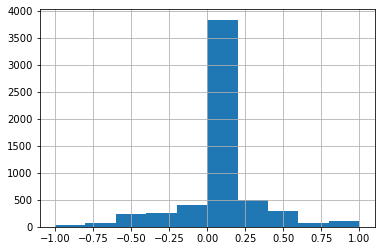

In [17]:
tw_text['polarity'].hist(label='polarity scores')

<AxesSubplot:>

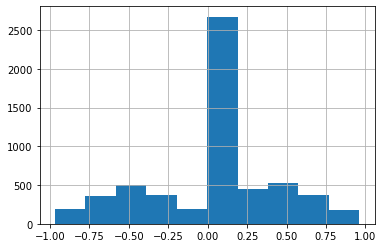

In [18]:
tw_text['compound'].hist(label='compound scores')

<AxesSubplot:>

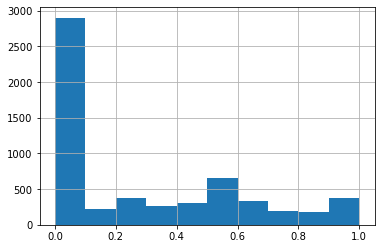

In [19]:
tw_text['subjectivity'].hist(label='subjectivity score')

Overall, the distribution of sentiment scores is not particularly informative. The tweets seem to be neutral overall, with low degrees of subjectivity. This could be due to equal usage of #LetsGoBrandon in a satirical manner, owing to its origins covered in Assignment 1, and a vitriolic manner, due to its translation to F*** Joe Biden. This is purely speculative, and would require a deeper analysis to accurately evaluate.

__Subset Tweets by Sentiment Scores and Explore Text__

In [20]:
#Subset Data
tw_text_negative = tw_text[tw_text["sentiment"]=="negative"]
tw_text_positive = tw_text[tw_text["sentiment"]=="positive"]
tw_text_neutral = tw_text[tw_text["sentiment"]=="neutral"]

In [21]:
#generate wordclouds
stopwords = nltk.corpus.stopwords.words('english') + \
            ['letsgobrandon', 'lets', 'go', 'brandon', 'like', \
             'amp', 'people', 'day', 'today', 'get', 'ad']

def black_color_func(word, font_size, position,orientation,random_state=None, **kwargs):
    '''
    Changes our word cloud to a black and white wordcloud
    '''
    return("hsl(0,100%, 1%)")

# wordcloud function
def generate_wordcloud(dataframe, custom_stopwords=[], comment_words=''):
    '''
    Plot a black & white wordcloud
    
    Inputs:
        dataframe: a dataframe with tweets
        custom_stopwords: additional stopwords to include
        comment_words: words to be a part of the word cloud
    Outputs:
        a wordcloud plot
    '''
    for val in dataframe["text"]:

        # typecaste each val to string
        val = str(val)

        # split the value
        tokens = val.split()

        # Converts each token into lowercase
        for i in range(len(tokens)):
            tokens[i] = tokens[i].lower()

        comment_words += " ".join(tokens)+" "

    wordcloud = WordCloud(width = 3000, height = 2000,
                max_words = 500,
                background_color ='white',
                stopwords = stopwords+custom_stopwords,
                min_font_size = 10).generate(comment_words)
    wordcloud.recolor(color_func = black_color_func)
    # plot the WordCloud image                      
    plt.figure(figsize = (15, 10))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
#     plt.tight_layout(pad = 0)

    plt.show()

__Positive Word Cloud__

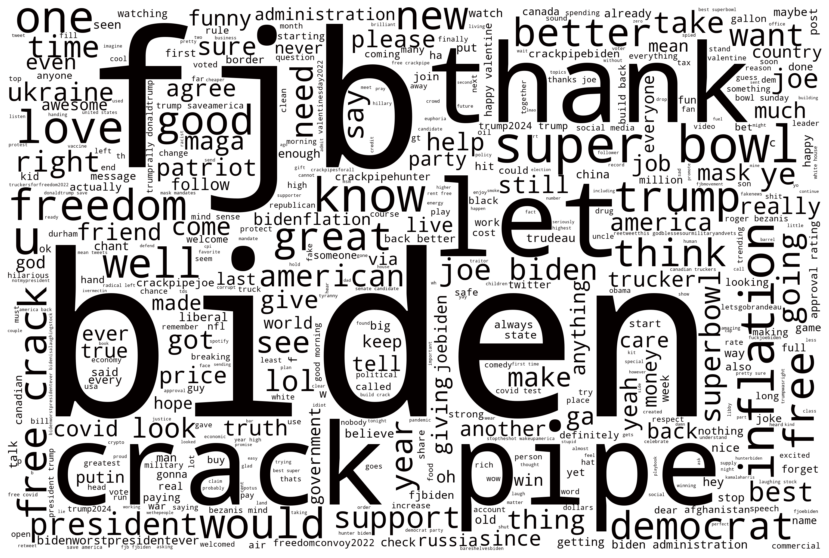

In [22]:
generate_wordcloud(tw_text_positive)

__Negative Word Cloud__

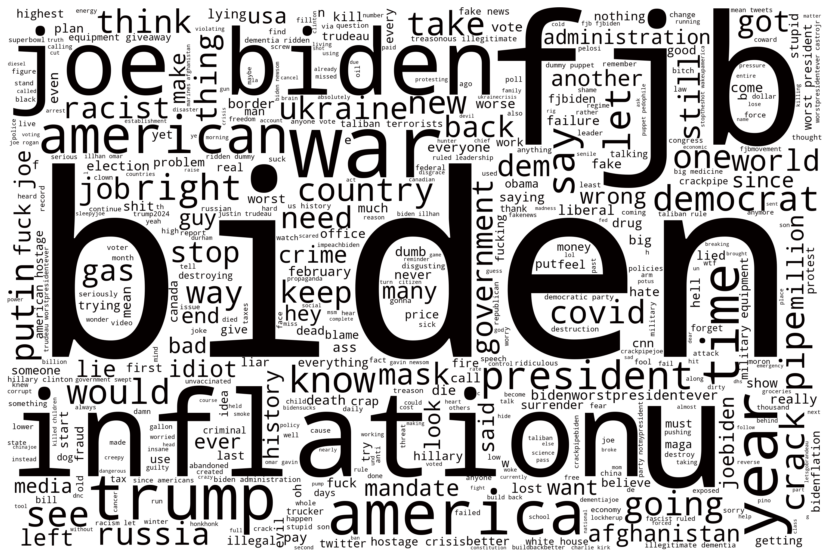

In [23]:
generate_wordcloud(tw_text_negative)

__Neutral Word Cloud__

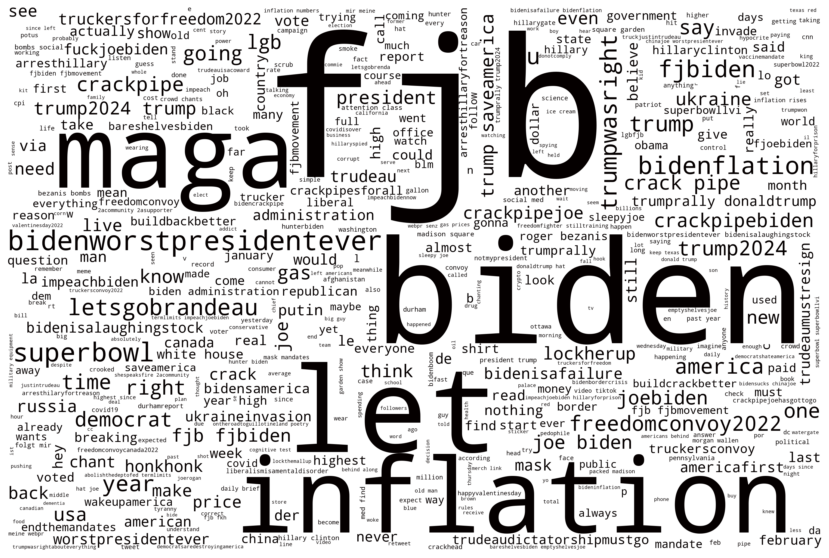

In [24]:
generate_wordcloud(tw_text_neutral)

Our wordclouds reveal that most of the positive tweets are made in reference to the Superbowl or Valentine's day, explaining the presence of words like 'super' and 'love'. Outside of these words with explicit positive connotations, the wordclouds don't reveal much variations across tweets of different sentiment scores.  The same words and themes feature prominently, such as 'Joe', 'Biden', 'F** Joe Biden', 'inflation', 'crack pipes', and pro-trump slogans. 

Despite the lack of variation across sentiment, the wordclouds contain several interesting consistencies. The first is use of explicity anti-Joe Biden words such as "fjb" accompanied with mentions of "democrats" and other actors aligned with the Biden administration.

The second is the use of words associated with pro-Trump right-wing populism such as "maga", "freedom convoy" and "trump 2024" which draw on several political movements aligned with Donald Trump such as the ongoing trucker convoy in Canada protesting vaccine lockdowns. 

The third is the common theme of "inflation", "crack", and "war" in the "ukraine". These are explicit criticisms of the Biden administration's economic policies, drug enforcement policies and foreign policy respecitvely. They reference, in order, record high inflation, the use of harm-reduction strategies that offer addicts sterile drug use paraphernalia and efforts at easing tensions between Russia and The Ukraine. These arguments provide justification for users' opposition to Joe Biden. Additionally, mentions of 'crime' and 'afghanistan' are also present as criticisms of Biden being soft on crime and terrorism (hence the chaotic pullout from Afghanistan) respectively.

### Step 6: Text Analysis

__Create Necessary Functions__

In [25]:
#Use our wordcloud results to create a new stopword list

custom_stopwords = ['letsgobrandon', 'lets', 'go', 'brandon', 'u', 'amp', 'superbowl', \
                    'amp', 'people', 'day', 'today', 'get', 'ad', 'love', 'super', 'bowl', \
                    'valentine', 'valentines', 'u']

STOP = nltk.corpus.stopwords.words('english') + custom_stopwords

def prepare_trigrams(series):
    '''
    Generates trigrams from a pandas series object (single column)\
    trigrams are lemmatized tokens using nltk's lemmatizer
    '''
    lemmas = series.apply(get_lemmas)
    title_trigrams = [list(trigrams(title)) for title in lemmas]
    title_trigrams = list(itertools.chain(*title_trigrams))
    trigram_counts = collections.Counter(title_trigrams)
    return pd.DataFrame(trigram_counts.most_common(25), columns=['trigram', 'count'])

def get_lemmas(text):
    '''
    Gets lemmas for a string input, excluding stop words, \
    punctuation, as well as a set of study-specific stop-words
    '''
    tokens = [i for i in nltk.word_tokenize(text.lower()) if i not in STOP]
    lemmas = [nltk.stem.WordNetLemmatizer().lemmatize(t, get_wordnet_pos(t)) for t in tokens]
    return lemmas

def get_wordnet_pos(word):
    '''
    Tags each word with its Part-of-speech indicator -- \
    specifically used for lemmatization in the get_lemmas function
    '''
    tag = nltk.pos_tag([word])[0][1][0].upper()
    tag_dict = {"J": nltk.corpus.wordnet.ADJ,
                "N": nltk.corpus.wordnet.NOUN,
                "V": nltk.corpus.wordnet.VERB,
                "R": nltk.corpus.wordnet.ADV}

    return tag_dict.get(tag, nltk.corpus.wordnet.NOUN)


def plot_top_lemmas(series, data_description, n = 20):
    '''
    Plots the top `n` lemmas in a Pandas series of strings.
    '''
    lemmas = series.apply(get_lemmas)

    # Extend list so that it contains all words/parts of speech for all the captions
    lemmas_full = []
    for i in lemmas:
        lemmas_full.extend(i)

    nltk.FreqDist(lemmas_full).plot(n, title='Top {} Lemmas Overall for '.format(n) + data_description);
    return

__Identify Most Popular Lemmas in Tweets__

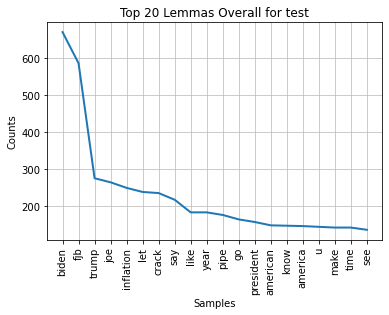

In [26]:
plot_top_lemmas(tw_text["text"], "test")

__Generate Trigram Plots__

In [27]:
import seaborn as sns
import networkx as nx

In [28]:
def produce_trigram_plots(trigram_df, title=None):
    plt.figure(figsize=(10,5))
    sns.barplot(x='trigram', y='count', data=trigram_df)
    plt.xticks(rotation=90);
    if title != None:
        plt.title('{}'.format(title))
    d = trigram_df.set_index('trigram').T.to_dict('records')
    G = nx.Graph()

    # Create connections between nodes
    for k, v in d[0].items():
        G.add_edge(k[0], k[1], weight=(v*10))
        G.add_edge(k[1], k[2], weight=(v*10))

    fig, ax = plt.subplots(figsize=(15, 10))

    pos = nx.spring_layout(G, k=1)

    # Plot networks
    nx.draw_networkx(G, pos,
                     font_size=12,
                     width=3,
                     with_labels = False,
                     ax=ax)

    # Create offset labels
    for key, value in pos.items():
        x, y = value[0] + .135, value[1] + .045
        ax.text(x, y,
                s=key,
                bbox=dict(facecolor='red', alpha=0.25),
                horizontalalignment='center', fontsize=10)

    plt.show()

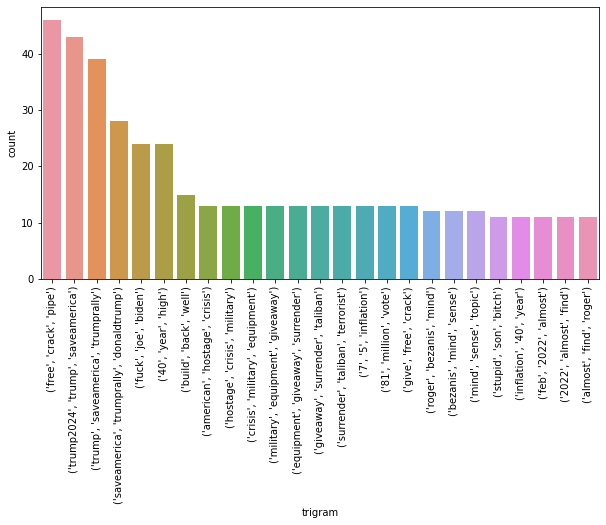

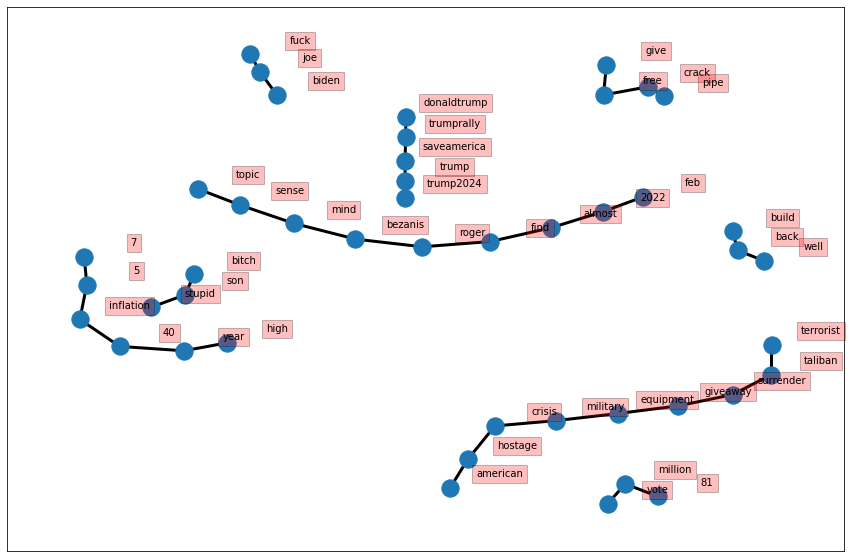

In [29]:
produce_trigram_plots(prepare_trigrams(tw_text["text"]))

Our trigram text analysis is the most telling. The first barplot conclusively demonstrates the consistent use of #LetsGoBrandon in the common context of:

 1. A synonym for "F** Joe Biden"
 2. Indicating political opposition to Joe Biden
 3. Justifying this opposition through negative outcomes
 4. Engaging in the first-three from the perspectives of a conservative
 
The trigrams demonstrate the salience of policy criticisms and pro-trump messaging in tweets that accompany the #LetsGoBrandon hashtag. ('free', 'crack', 'pipe') references the common conservative criticism of liberal harm-reduction policies as amounting to nothing more than the distribution of free drug use kits to citizens. Meanwhile, ('40', 'year', 'high') and ('7', '5', 'january') reference the record 40-year high inflation rate of 7.5% recorded in January. Finally, criticisms of Biden's handling of tensions between Russia and The Ukraine and the chaotic withdrawal from Afghanistan ('military', 'equipment', 'giveaway') accompany the hashtag with a high level of frequency.

The attribution of high inflation, drug use and foreign policy disasters provide the hashtags with contextual meaning, interpreted together with the post to provide reasons for opposition to Joe Biden. These arguments are heavily manipulative and propagated by conservative media personalities. Nonetheless, they have been wholly imbibed by consumers of their content, who then spread these talking points on social media platforms.

The tweets also contains mentions of explicit support for the trump campaign, with trigrams such as (trump20204, trump, saveamerica) and (trump, saveamerica, trumprally). These tweets are made on a public platform, openly broadcasting the users' political opposition to Joe Biden. Additionally, they also serve as a galvanising symbol, motivating like-minded users to vote republican in the upcoming midterm elections. These create a sense of community and solidarity amongst members of the in-group, encouraging them to spread the gospel of right-wing talking points. At the same time a clear boundary is carved between them and the out-group of non-conservatives.

The alternative medicines promoted by roger bezanis feature prominently as well, showing a link between the anti-vaccine movement and the current conservative base. In sum, these observations lead me to conclude that the #LetsGoBrandon hashtag is consistently used to make repeated arguments indicating political opposition to Joe Biden from a conservative perspective. This makes the cultural phenomenon I am studying a replica of a broader legisign

### Additional Analysis

For additional analyis, I propose four steps to allow me to answer my question.

First, my results do not show strong evidence of prominent conservative influencers being involved in the hashtag's current use. There is a disconnect with the qualitative evidence in assignment 1 that traced the origins of "Lets Go Brandon"'s virality to the social media posts of popular conservative commentators online. I propose using the reply_id and screen names of tweets in my database and any associated retweets/favourites to trace interactions between users and influencers. I could then construct a network object linking accounts together that have used this hashtag, demonstrating how the userbase has shifted over time from larger influencers to smaller influencers and regular users.       

Second, my results do not provide sufficient evidence of the satirical elements in #LetsGoBrandon's use. The word clouds failed to pick up on the presence of satire, although the sentiment analysis did indicate that positive tweets made up 29% of the dataset. I could possibly perform deeper text analysis, using word embeddings and pos tagging to identify varying contextual usage of the hashtag and possibly observe its use in a comedic context.

Third, my text analysis results are only limited to a set of approximately 7,000 unique tweets after text cleaning. I can widen this dataset by using alternative scraping tools such as twint and integrating other social media platforms onto my database. For example, I can scrape reddit posts from conservative subreddits addressing the virality of the #LetsGoBrandon hashtag to better understand how conservative communities interact with the original legisign.

Fourth, my analysis does not consider the images attached to the tweets in my database. Downloading images requires manual scraping which can be computationally expensive. However there are existing python packages that simplify this process. I could crawl through tweets using this hashtag and analyze image contents with the Google Cloud Vision API. This process will undoubtedly be tricky as attached images are likely to include a large number of political memes whose meanings require a significant degree of contextual knowledge to understand.